In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils

#### Get the CESM tseries files for nutrients and other vars

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1'

In [3]:
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'

In [4]:
path

'/glade/scratch/kristenk/archive/g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1/ocn/proc/tseries/month_1'

In [5]:
variables = ['coccoC','diatC','spC']

In [6]:
%%time

ds_list = []

print(f'reading {case}')

ds = xr.Dataset()

for v in variables:
    
    print(v)

    files = sorted(glob(f'{path}/{case}.pop.h.{v}.??????-??????.nc'))       

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1
coccoC
diatC
spC
CPU times: user 1 s, sys: 71.1 ms, total: 1.07 s
Wall time: 3.09 s


#### Get grid

In [7]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

### get just the last 20 years of simulation (1999 to 2018)

In [8]:
ds = ds.isel(time=slice(492,732))

### Make a climatology for that

In [9]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [10]:
ds_clim = ds.groupby('time.month').mean('time')

In [11]:
variables

['coccoC', 'diatC', 'spC']

In [12]:
ds_clim_100m = xr.Dataset()

# for var in ['Fe', 'NO3', 'PO4', 'SiO3', 'DIC', 'TEMP']:
#     ds_clim_100m[var] = ds_clim[var].isel(z_t=slice(0,10)).mean(dim='z_t')
    
for var in ['coccoC', 'diatC', 'spC']:
    ds_clim_100m[var] = ds_clim[var].isel(z_t_150m=slice(0,10)).mean(dim='z_t_150m')

In [13]:
ds_clim_100m.load()

<xarray.Dataset>
Dimensions:  (month: 12, nlat: 384, nlon: 320)
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables:
    coccoC   (month, nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    diatC    (month, nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    spC      (month, nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan

In [14]:
mons = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

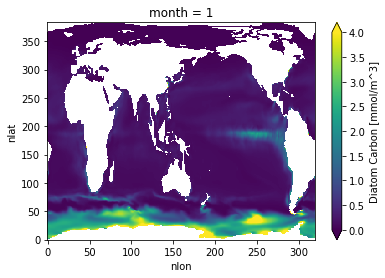

In [17]:
ds_clim_100m['diatC'].isel(month=0).plot(vmin=0,vmax=4)

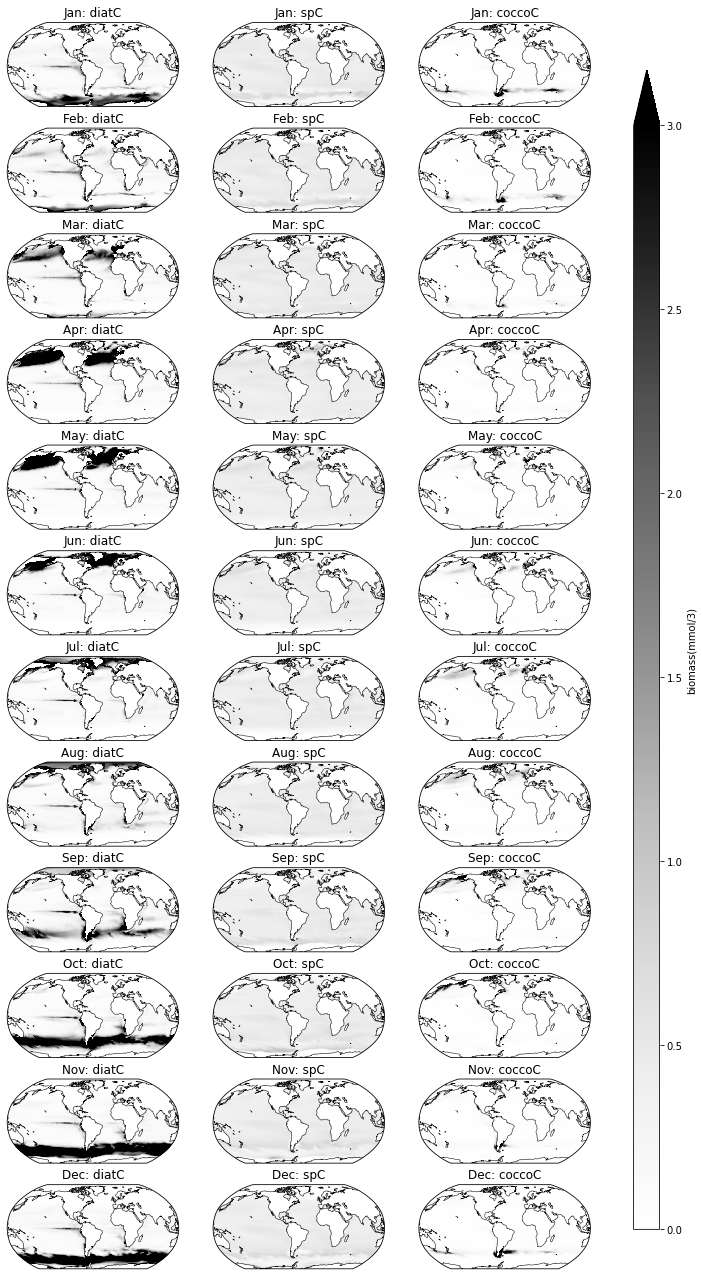

In [22]:
fig = plt.figure(figsize=(12,23))

for row in np.arange(1,13):
    ts=row-1
    
    plot = row*3 - 2
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(mons[ts]+': diatC', fontsize=12)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_clim_100m['diatC'].isel(month=ts))
    pc=ax.pcolormesh(lon, lat, field, 
                     vmin=0,vmax=3,
                     cmap='Greys', transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*3 - 1
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(mons[ts]+': spC', fontsize=12)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_clim_100m['spC'].isel(month=ts))
    pc=ax.pcolormesh(lon, lat, field,                      
                     vmin=0,vmax=3,
                     cmap='Greys', transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    plot = row*3
    ax = fig.add_subplot(12,3,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(mons[ts]+': coccoC', fontsize=12)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_clim_100m['coccoC'].isel(month=ts))
    pc=ax.pcolormesh(lon, lat, field, 
                    vmin=0,vmax=3,
                     cmap='Greys', transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, label='biomass(mmol/3)', extend='max')